# Implémentation de l'algorithme CQR

### Introduction

Ce notebook implémente l'algorithme **CQR (Conformalized Quantile Regression)** afin de prédire des **intervalles de prédiction** pour le prix de voitures à partir de leurs caractéristiques.

Dans le cadre de la CQR, deux régresseurs quantiles sont utilisés pour effectuer les prédictions initiales. Contrairement à la méthode CV+, la calibration ne se fait pas par validation croisée, mais en utilisant les **scores de conformité** calculés sur un ensemble de calibration dédié (distinct de l'entraînement).

Sous des hypothèses d'échangeabilité des données, l'algorithme CQR produit des intervalles de prédiction avec des garanties théoriques sur la couverture. Les intervalles obtenus sont **adaptatifs** : ils s'appuient sur des régresseurs quantiles qui capturent localement la variabilité des données (hétéroscédasticité), puis sont "corrigés" globalement pour garantir le taux d'erreur cible.

### Mise en place

1.  **Séparation des données :** Les données sont séparées en trois ensembles : entraînement (*proper training set*), calibration et test.
2.  **Entraînement du modèle :** Deux régresseurs quantiles sont entraînés sur l'ensemble d'entraînement (pour estimer les bornes brutes).
3.  **Calibration :**
    * Les régresseurs quantiles effectuent des prédictions sur l'ensemble de calibration.
    * On calcule les **scores de conformité** sur cet ensemble. Ces scores mesurent l'écart (ou l'erreur signée) entre les bornes prédites et les vraies valeurs.
    * On détermine une constante de correction $\hat{Q}$ correspondant au quantile approprié de ces scores.
4.  **Construction des intervalles :**
    * Les modèles prédisent les bornes initiales sur l'ensemble de test.
    * Ces bornes sont ajustées (élargies ou décalées) en leur appliquant la constante de correction $\hat{Q}$ issue de l'étape de calibration.
5. **Évaluation du modèle:** Le modèle est évalué sur l'ensemble de test en utilisant diverses métriques.

### Chargement des données

In [ ]:
import polars as pl
import numpy as np

# Polars display options
pl.Config.set_tbl_hide_column_data_types(True)
pl.Config.set_tbl_hide_dataframe_shape(True)
pl.Config.set_float_precision(2)

# Load preprocessed data
df = pl.read_parquet("../../data/car_prices_clean.parquet")

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (19161, 18)


Price,Levy tax,Brand,Model,Production year,Category,Leather interior,Fuel type,Engine volume (L),Mileage (km),Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo
13328,1399,"""LEXUS""","""RX 450""",2010,"""Jeep""",true,"""Hybrid""",3.50,186005,6.00,"""Automatic""","""4x4""",4,"""Left wheel""","""Silver""",12,false
16621,1018,"""CHEVROLET""","""Equinox""",2011,"""Jeep""",false,"""Petrol""",3.00,192000,6.00,"""Tiptronic""","""4x4""",4,"""Left wheel""","""Black""",8,false
8467,null,"""HONDA""","""FIT""",2006,"""Hatchback""",false,"""Petrol""",1.30,200000,4.00,"""Variator""","""Front""",4,"""Right-hand drive""","""Black""",2,false
3607,862,"""FORD""","""Escape""",2011,"""Jeep""",true,"""Hybrid""",2.50,168966,4.00,"""Automatic""","""4x4""",4,"""Left wheel""","""White""",0,false
11726,446,"""HONDA""","""FIT""",2014,"""Hatchback""",true,"""Petrol""",1.30,91901,4.00,"""Automatic""","""Front""",4,"""Left wheel""","""Silver""",4,false


### Définition des données du modèle

In [22]:
target = "Price"
numerical_features = [
    "Production year",
    "Leather interior",
    "Engine volume (L)",
    "Mileage (km)",
    "Cylinders",
    "Doors",
    "Airbags",
    "Turbo",
]
categorical_features = [
    "Brand",
    "Category",
    "Fuel type",
    "Gear box type",
    "Drive wheels",
    "Wheel",
    "Color",
]
features = numerical_features + categorical_features

f"Columns not used: {[col for col in df.columns if col not in features + [target]]}"

"Columns not used: ['Levy tax', 'Model']"

### Séparation des données

La taille de l'ensemble de calibration est choisie de manière à garantir un taux de couverture satisfaisant, tandis que la taille de l'ensemble de test permet de généraliser les performances du modèle.

In [23]:
from sklearn.model_selection import train_test_split

X = df.select(features)
y = df.get_column("Price")

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)
X_calib, X_test, y_calib, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train set size (60%): {X_train.shape[0]}")
print(f"Calibration set size (20%): {X_calib.shape[0]}")
print(f"Test set size (20%): {X_test.shape[0]}")

Train set size (60%): 11496
Calibration set size (20%): 3832
Test set size (20%): 3833


### Définition du modèle

Le régresseur utilisé est `sklearn.ensemble.HistGradientBoostingRegressor` qui est un modèle de gradient boosting efficace pour les tâches de régression. Ce modèle est choisi car il ne nécessite pas de normalisation des données numériques et gère nativement les données catégorielles et manquantes.

Le paramètre `loss` est défini sur `"quantile"` pour entraîner un régresseur quantile. Deux modèles sont entraînés : un pour le quantile inférieur ($\frac{\alpha}{2}$) et un pour le quantile supérieur (1 - $\frac{\alpha}{2}$).

In [24]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import clone

base_model = HistGradientBoostingRegressor(
    loss="quantile",
    quantile=None,
    categorical_features="from_dtype",
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,
)

alpha = 0.1  # 90% prediction intervals
q_low, q_high = alpha / 2, 1 - alpha / 2
print(f"Quantiles: {q_low}, {q_high}")
model_low = clone(base_model).set_params(quantile=q_low)
model_high = clone(base_model).set_params(quantile=q_high)

Quantiles: 0.05, 0.95


### Entraînement du modèle

Les hyperparamètres du modèle sont optimisés sur l'ensemble d'entraînement avec `sklearn.model_selection.HalvingRandomSearchCV` avec une cross-validation à 5 plis sur l'ensemble d'entraînement. Les meilleurs hyperparamètres sont ensuite utilisés pour entraîner le modèle final sur l'ensemble d'entraînement complet (`refit=True`).

In [25]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint, uniform

param_distributions = {
    "max_iter": randint(100, 300),
    "max_leaf_nodes": randint(20, 80),
    "learning_rate": uniform(0.05, 0.15),
    "min_samples_leaf": randint(20, 100),
    "l2_regularization": uniform(0, 0.1),
}

base_search = HalvingRandomSearchCV(
    estimator=None,
    param_distributions=param_distributions,
    n_candidates=50,
    min_resources=200,
    cv=5,
    n_jobs=-1,
    random_state=42,
    refit=True,
)

search_low = clone(base_search).set_params(estimator=model_low)
search_high = clone(base_search).set_params(estimator=model_high)

search_low.fit(X_train, y_train)
search_high.fit(X_train, y_train);

### Predictions sur l'ensemble de test

In [26]:
df_test_QR = pl.DataFrame(
    {
        "True Price": y_test,
        "Lower Bound": search_low.best_estimator_.predict(X_test),
        "Upper Bound": search_high.best_estimator_.predict(X_test),
    }
).with_columns(
    (pl.col("Upper Bound") - pl.col("Lower Bound")).alias("Interval Width"),
)

### Distribution de la largeur d'intervalle

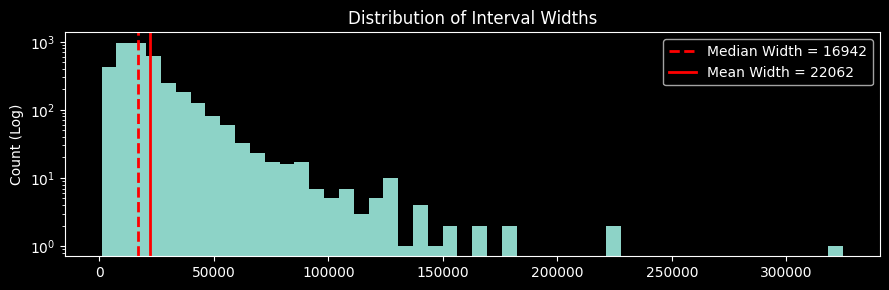

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3))
plt.hist(df_test_QR["Interval Width"], bins=50, log=True)
plt.axvline(
    df_test_QR["Interval Width"].median(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Median Width = {df_test_QR['Interval Width'].median():.0f}",
)
plt.axvline(
    df_test_QR["Interval Width"].mean(),
    color="red",
    linewidth=2,
    label=f"Mean Width = {df_test_QR['Interval Width'].mean():.0f}",
)
plt.title("Distribution of Interval Widths")
plt.ylabel("Count (Log)")
plt.legend()
plt.tight_layout()

### Évaluation de la régression quantile non conformalisée (QR)

In [28]:
from utils import coverage, pinball_loss

df_test_QR.select(
    coverage("Lower Bound", "Upper Bound"),
    coverage(0, "Lower Bound").name.suffix(f" q{q_low}"),
    coverage(0, "Upper Bound").name.suffix(f" q{q_high}"),
    pinball_loss("True Price", "Lower Bound", q_low),
    pinball_loss("True Price", "Upper Bound", q_high),
    pl.col("Interval Width").mean().round(),
)

Coverage,Coverage q0.05,Coverage q0.95,Pinball q_0.05,Pinball q_0.95,Interval Width
"""82.5%""","""7.6%""","""90.1%""",668,1088,22062.00


Le taux de couverture global (82.6%) est nettement inférieur au taux attendu (90%).

Toutefois, malgré cette sous-couverture globale, le regresseur quantile est meilleur que l'approche SCP. La pinball loss est nettement plus faible pour les deux bornes et la largeur moyenne des intervalles est également plus faible. 

La conformalisation devrait améliorer le taux de couverture.

### Conformalized quantile regression (CQR)

In [29]:
# 1. Predict quantiles on calibration set
cal_low_pred = search_low.best_estimator_.predict(X_calib)
cal_high_pred = search_high.best_estimator_.predict(X_calib)

# 2. Compute nonconformity scores
nonconformity_scores = np.maximum(cal_low_pred - y_calib, y_calib - cal_high_pred)

# 3. Compute quantile of nonconformity scores
q_level = np.ceil((len(y_calib) + 1) * (1 - alpha)) / len(y_calib)
qhat = np.quantile(nonconformity_scores, q_level, method="linear")

f"CQR calibration qhat (α={alpha}): {qhat:.3f} at level {q_level:.4f}"

'CQR calibration qhat (α=0.1): 787.838 at level 0.9003'

### Distribution des scores de calibration

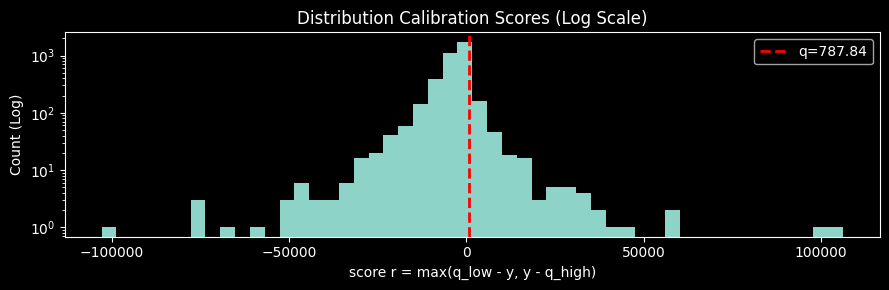

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3))
plt.hist(nonconformity_scores, bins=50, log=True)
plt.axvline(qhat, color="red", linestyle="--", linewidth=2, label=f"q={qhat:.2f}")
plt.title("Distribution Calibration Scores (Log Scale)")
plt.xlabel("score r = max(q_low - y, y - q_high)")
plt.ylabel("Count (Log)")
plt.legend()
plt.tight_layout()

### Prédictions des quantiles conformalisés (CQR) sur l'ensemble de test

In [31]:
df_test_CQR = df_test_QR.with_columns(
    (pl.col("Lower Bound") - qhat).name.suffix(" CQR"),
    (pl.col("Upper Bound") + qhat).name.suffix(" CQR"),
).with_columns(
    (pl.col("Upper Bound CQR") - pl.col("Lower Bound CQR")).alias("Interval Width CQR")
)

# Largeur relative des intervalles par rapport au prix
df_test_CQR = df_test_CQR.with_columns(
    pl.col("Interval Width CQR")
    .truediv("True Price")
    .mul(100)
    .round(2)
    .alias("CQR Interval Width Relative to True Price"),
)

df_test_CQR = pl.concat([df_test_CQR, X_test], how="horizontal")
df_test_CQR.head()

True Price,Lower Bound,Upper Bound,Interval Width,Lower Bound CQR,Upper Bound CQR,Interval Width CQR,CQR Interval Width Relative to True Price,Production year,Leather interior,Engine volume (L),Mileage (km),Cylinders,Doors,Airbags,Turbo,Brand,Category,Fuel type,Gear box type,Drive wheels,Wheel,Color
29793,3173.94,14112.21,10938.27,2386.10,14900.05,12513.95,42.00,2004,true,3.50,180800,6.00,4,2,false,"""CHRYSLER""","""Limousine""","""Petrol""","""Automatic""","""Front""","""Left wheel""","""Pink"""
5802,923.13,18797.47,17874.34,135.29,19585.31,19450.02,335.23,2013,true,3.50,107800,6.00,4,12,false,"""MERCEDES-BENZ""","""Sedan""","""Diesel""","""Automatic""","""Rear""","""Left wheel""","""Grey"""
12544,2171.12,16236.08,14064.95,1383.29,17023.91,15640.63,124.69,2013,true,2.40,98456,4.00,4,0,false,"""HYUNDAI""","""Sedan""","""Petrol""","""Automatic""","""Front""","""Left wheel""","""Black"""
21326,10440.70,25792.45,15351.75,9652.86,26580.29,16927.43,79.37,2012,true,2.40,113000,4.00,4,8,false,"""TOYOTA""","""Sedan""","""Petrol""","""Tiptronic""","""Front""","""Left wheel""","""Silver"""
26255,15417.95,28182.52,12764.57,14630.12,28970.36,14340.24,54.62,2011,true,2.00,142000,4.00,4,4,false,"""HYUNDAI""","""Jeep""","""Diesel""","""Automatic""","""Front""","""Left wheel""","""Black"""


### Évaluation des performances (CQR)

In [32]:
df_test_CQR.select(
    coverage("Lower Bound CQR", "Upper Bound CQR").alias("Coverage CQR"),
    coverage(0, "Lower Bound CQR").name.suffix(f" CQR q{q_low}"),
    coverage(0, "Upper Bound CQR").name.suffix(f" CQR q{q_high}"),
    pinball_loss("True Price", "Lower Bound CQR", q_low),
    pinball_loss("True Price", "Upper Bound CQR", q_high),
    pl.col("Interval Width CQR").mean().cast(pl.Int32),
)

Coverage CQR,Coverage CQR q0.05,Coverage CQR q0.95,Pinball q_0.05,Pinball q_0.95,Interval Width CQR
"""90.6%""","""2.9%""","""93.5%""",673,1066,23638


Les bornes calibrées corrigent le biais résiduel des régressions quantiles: le duo (q_low, q_high) sous-couvre légèrement, l'agrégat q̂  appris sur l'échantillon de calibration élargit symétriquement l'intervalle pour corriger la sous-couverture et atteindre la couverture cible, sans hypothèses fortes sur la distribution des erreurs. La pinball loss reste similaire à celle des régressions quantiles non conformalisées.

### Couverture par décile de prix (QR vs CQR)

In [33]:
df_test_CQR.with_columns(
    pl.col("True Price").qcut(10, include_breaks=True).alias("True Price Decile")
).group_by("True Price Decile").agg(
    coverage("Lower Bound", "Upper Bound").alias("Coverage QR"),
    coverage("Lower Bound CQR", "Upper Bound CQR").alias("Coverage CQR"),
    pl.col("Interval Width").mean().cast(pl.Int32),
    pl.col("Interval Width CQR").mean().cast(pl.Int32),
    pl.col("Lower Bound CQR").mean().round(0).alias("Avg Lower Bound CQR"),
    pl.col("Upper Bound CQR").mean().round(0).alias("Avg Upper Bound CQR"),
).sort("True Price Decile")

True Price Decile,Coverage QR,Coverage CQR,Interval Width,Interval Width CQR,Avg Lower Bound CQR,Avg Upper Bound CQR
"{627.00,""(-inf, 627]""}","""55.3%""","""85.3%""",21820,23395,33.00,23428.00
"{3293.00,""(627, 3293]""}","""93.1%""","""97.6%""",20637,22212,-48.00,22165.00
"{7213.00,""(3293, 7213]""}","""89.0%""","""93.6%""",13264,14840,1918.00,16758.00
"{10349.00,""(7213, 10349]""}","""90.3%""","""96.5%""",12227,13803,3883.00,17686.00
"{13485.00,""(10349, 13485]""}","""88.7%""","""95.2%""",14409,15985,5019.00,21004.00
"{16621.00,""(13485, 16621]""}","""91.0%""","""95.7%""",15030,16605,6210.00,22816.00
"{20385.00,""(16621, 20385]""}","""88.1%""","""94.0%""",17540,19115,7187.00,26303.00
"{26115.00,""(20385, 26115.00000000003]""}","""82.5%""","""89.1%""",22290,23866,7612.00,31479.00
"{39201.00,""(26115.00000000003, 39201]""}","""79.9%""","""84.6%""",30780,32355,10183.00,42539.00
"{inf,""(39201, inf]""}","""68.0%""","""74.1%""",53275,54850,11974.00,66824.00


Le taux de couverture des intervalles produit par la régression quantile par décile de prix montre que le modèle sous-couvre sur l'ensemble des déciles, avec des performances particulièrement mauvaise sur les véhicules les moins chers (1er décile) et les plus chers (10ème décile).

Le taux de couverture par décile de prix montre que le modèle a plus de difficultés à couvrir correctement les véhicules aux extrémités de la gamme de prix et en particulier le 10ème décile (les véhicules les plus chers), où la couverture tombe à 74,3%.

La conformalisation a permis de corriger partiellement mais uniformément ce problème aux différents déciles de prix.

### Largeurs d'intervalles moyenne vs kilométrage

In [34]:
import altair as alt

alt.data_transformers.enable("vegafusion")

_df_temp = df_test_CQR.filter(
    pl.col("Mileage (km)").is_between(0, 500_000)
    & pl.col("Interval Width CQR").is_between(0, 150_000)
)

alt.Chart(_df_temp).mark_rect().encode(
    alt.X("Interval Width CQR:Q").bin(maxbins=50),
    alt.Y("Mileage (km):Q").bin(maxbins=50),
    alt.Color("count()").scale(type="sqrt"),
).properties(title="CQR Interval Width vs Mileage (Density Plot)")

alt.Chart(...)

**Main Concentration:** The highest density of records (darkest blue) is clustered at low-to-mid mileage (approx. 80,000 to 200,000 km) and a low absolute interval width (approx. 10,000 to 30,000). This suggests the model is most frequently making predictions for cars in this range and is generating relatively tight absolute intervals for them.

**Low Mileage Behavior:** For very low mileage vehicles (0 to 80,000 km), the distribution is much more spread out vertically. This indicates a high variance in prediction uncertainty; some predictions have very narrow intervals, while others have extremely wide intervals (up to 150,000).

**High Mileage Behavior:** For vehicles with high mileage (over 320,000 km), there are very few data points, and the interval widths are generally low to moderate.

### Largeurs d'intervalles relatifs aux vrai prix moyen vs kilométrage

In [35]:
_df_temp = df_test_CQR.filter(
    pl.col("Mileage (km)").is_between(0, 500_000)
    & pl.col("CQR Interval Width Relative to True Price").is_between(0, 300)
)

alt.Chart(_df_temp).mark_rect().encode(
    alt.X("CQR Interval Width Relative to True Price:Q").bin(maxbins=50),
    alt.Y("Mileage (km):Q").bin(maxbins=50),
    alt.Color("count()").scale(type="sqrt"),
).properties(
    title="CQR Interval Width Relative to True Price (%) vs Mileage (Density Plot)"
)

alt.Chart(...)

La plupart des intervalles de prédiction sont relativement étroits (entre 50% et 120% du prix réel). Cependant, pour les véhicules avec un faible kilométrage, on observe une plus grande variabilité dans la largeur des intervalles, ce qui suggère une incertitude accrue dans les prédictions pour ces véhicules.

In [36]:
_df_temp = df_test_CQR.filter(
    pl.col("CQR Interval Width Relative to True Price").is_between(0, 600)
    & pl.col("True Price").is_between(0, 200_000)
)

alt.Chart(_df_temp).mark_rect().encode(
    alt.X("CQR Interval Width Relative to True Price:Q").bin(maxbins=50),
    alt.Y("True Price:Q").bin(maxbins=50),
    alt.Color("count()").scale(type="sqrt"),
).properties(
    title="CQR Relative Interval Width to True Price vs True Price (Density Plot)"
)

alt.Chart(...)

On observe clairement une relation inverse entre le prix réel et la largeur relative des intervalles de prédiction: les véhicules moins chers ont des intervalles proportionnellement plus larges, tandis que les véhicules plus chers bénéficient d'intervalles plus étroits en pourcentage de leur prix.

In [37]:
_df_temp = df_test_CQR.filter(
    pl.col("Production year").is_between(1990, 2020)
    & pl.col("Interval Width CQR").is_between(0, 150_000)
)

alt.Chart(_df_temp).mark_rect(clip=True).encode(
    alt.X("Production year:Q").bin(maxbins=50),
    alt.Y("Interval Width CQR:Q").bin(maxbins=50),
    alt.Color("count()").scale(type="sqrt"),
).properties(title="CQR Interval Width vs Production year (Density Plot)")

alt.Chart(...)

### Analyse de la couverture par sous-groupes

In [38]:
df_test_CQR.group_by("Brand").agg(
    coverage("Lower Bound CQR", "Upper Bound CQR"), pl.len().alias("Count")
).sort("Count", descending=True).head(10)

Brand,Coverage,Count
"""HYUNDAI""","""92.5%""",761
"""TOYOTA""","""89.9%""",755
"""MERCEDES-BENZ""","""91.9%""",383
"""FORD""","""89.7%""",223
"""HONDA""","""89.0%""",210
"""CHEVROLET""","""91.4%""",209
"""LEXUS""","""94.1%""",205
"""BMW""","""89.3%""",196
"""NISSAN""","""88.4%""",146
"""SSANGYONG""","""97.1%""",103


In [39]:
df_test_CQR.group_by("Fuel type").agg(
    coverage("Lower Bound CQR", "Upper Bound CQR"), pl.len().alias("Count")
).sort("Count", descending=True)

Fuel type,Coverage,Count
"""Petrol""","""90.6%""",2018
"""Diesel""","""89.8%""",783
"""Hybrid""","""91.1%""",741
"""LPG""","""93.2%""",176
"""CNG""","""89.4%""",94
"""Plug-in Hybrid""","""85.0%""",20
"""Hydrogen""","""100.0%""",1


In [40]:
df_test_CQR.group_by("Production year").agg(
    coverage("Lower Bound CQR", "Upper Bound CQR"), pl.len().alias("Count")
).sort("Production year", descending=True).head(15)

Production year,Coverage,Count
2020,"""90.0%""",10
2019,"""93.4%""",61
2018,"""82.2%""",101
2017,"""91.2%""",193
2016,"""91.7%""",300
…,…,…
2010,"""93.1%""",289
2009,"""87.3%""",118
2008,"""92.7%""",151
2007,"""82.1%""",95


**Analyse par sous-groupes:**

La couverture peut varier légèrement selon les caractéristiques du véhicule (kilométrage, année, marque) toutefois ces variations restent plus limitées qu'avec l'algorithme SCP.